In [1]:
# -*- coding: utf-8 -*-

import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction import text
from nltk import pos_tag
from nltk.corpus import stopwords
from string import punctuation
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
import itertools
from scipy import interp
plt.rcParams['figure.figsize'] = [12, 8]  #set image size for display

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ninga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ninga\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ninga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


----------- QUESTION 1 -----------


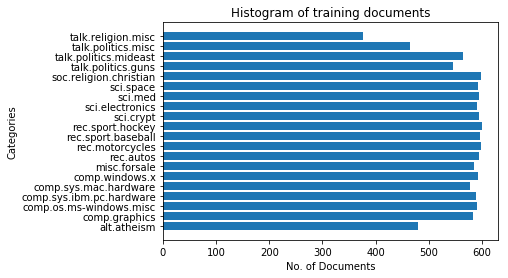

"\nplt.hist(newsgroups_train.target)\nplt.xticks(range(20), newsgroups_train.target_names)\nlocs, labels = plt.xticks()\nplt.setp(labels, rotation=25)\nplt.xlabel('Categories')\nplt.ylabel('# Documents')\nplt.title('Histogram of training documents')\nplt.grid(True)\nplt.show()\n"

In [13]:
"""
QUESTION 1
"""
print("----------- QUESTION 1 -----------")
from matplotlib import pyplot as plt

newsgroups_train = fetch_20newsgroups(subset='train')
cat_Ndocs = {}
for i in newsgroups_train.target_names:
		training_data = fetch_20newsgroups(subset='train', categories=[i])
		cat_Ndocs[i] = len(training_data.data)

fig,ax = plt.subplots()
plt.barh(list(newsgroups_train.target_names), list(cat_Ndocs.values()))
#labels = ax.get_yticklabels()
#plt.setp(labels, rotation=20, fontsize=10)
plt.xlabel('No. of Documents')
plt.ylabel('Categories')
plt.title('Histogram of training documents')
plt.show()

"""
plt.hist(newsgroups_train.target)
plt.xticks(range(20), newsgroups_train.target_names)
locs, labels = plt.xticks()
plt.setp(labels, rotation=25)
plt.xlabel('Categories')
plt.ylabel('# Documents')
plt.title('Histogram of training documents')
plt.grid(True)
plt.show()
"""


In [14]:
"""
QUESTION 2
"""
print("----------- QUESTION 2 -----------")

categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, 
                                   shuffle = True, random_state = 42)
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, 
                                  shuffle = True, random_state = 42)

stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

#  Converts Penn Treebank tags to WordNet.
def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

    
wnl = nltk.wordnet.WordNetLemmatizer()    

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(list_word)]

def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

analyzer = text.CountVectorizer().build_analyzer()

# Remove stopword, number and set min_df = 3
vectorizer = text.CountVectorizer(min_df=3, stop_words='english', analyzer=stem_rmv_punc, token_pattern = r'(?u)\b[A-Za-z][A-Za-z]+\b')

# For the train data
X_train_counts = vectorizer.fit_transform(train_dataset.data)
X_train_counts.toarray()

# For the test data
X_test_counts = vectorizer.transform(test_dataset.data)
X_test_counts.toarray()

# The following is the tfidf part
# For the train data
X_train_tfidf = text.TfidfTransformer().fit_transform(X_train_counts)
print('Shape of TF-IDF train matrices subset: ')
print(X_train_tfidf.shape)

# For the test data
X_test_tfidf = text.TfidfTransformer().fit_transform(X_test_counts)
print('Shape of TF-IDF test matrices subset: ')
print(X_test_tfidf.shape)

----------- QUESTION 2 -----------
Shape of TF-IDF train matrices subset: 
(4732, 16292)
Shape of TF-IDF test matrices subset: 
(3150, 16292)


In [5]:
"""
QUESTION 3
"""

print("----------- QUESTION 3 -----------")
# LSI dimensionality reduction
lsi = TruncatedSVD(n_components=50, random_state=42) 
X_train_LSI = lsi.fit_transform(X_train_tfidf)
X_test_LSI = lsi.transform(X_test_tfidf)
print(X_train_LSI.shape)
print(X_test_LSI.shape)


# NMF dimensionality reduction
nmf = NMF(n_components=50, random_state=42)
X_train_NMF = nmf.fit_transform(X_train_tfidf)
X_test_NMF = nmf.transform(X_test_tfidf)
print(X_train_NMF.shape)
print(X_test_NMF.shape)

# compare LSI & NMF
# for NMF
H = nmf.components_
sum_train_NMF = np.sum(np.array(X_train_tfidf - X_train_NMF.dot(H))**2)
sum_test_NMF = np.sum(np.array(X_test_tfidf - X_test_NMF.dot(H))**2)
print(sum_train_NMF)
print(sum_test_NMF)

# for LSI

----------- QUESTION 3 -----------
(4732, 50)
(3150, 50)
(4732, 50)
(3150, 50)
4142.637405379719
2838.3214283816583


In [7]:
# Plot ROC, for q4, q5, q6 
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

# Plot the confusion_matrix, for q4, q5, q6
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

----------- QUESTION 4 -----------

Hard Margin ----------------------------
Confusion Matrix: 
Confusion matrix, without normalization
[[1515   45]
 [  42 1548]]


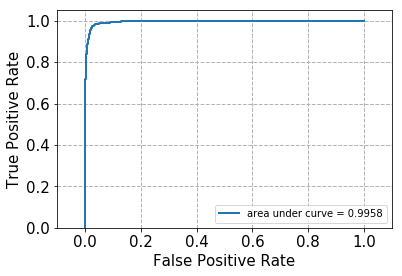

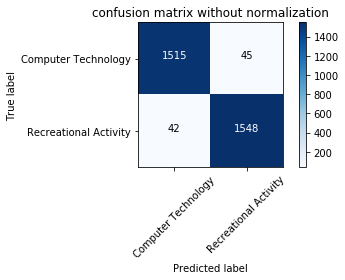

Accuracy: 0.9723809523809523
Recall: 0.9735849056603774
Precision: 0.9717514124293786
F1-Score: 0.9726672950047125

Soft Margin ----------------------------
Confusion Matrix: 
Confusion matrix, without normalization
[[ 540 1020]
 [   0 1590]]


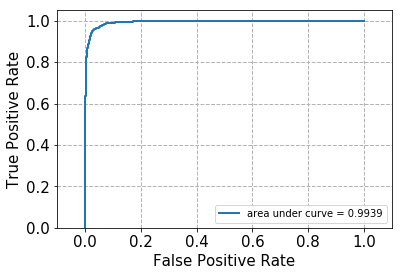

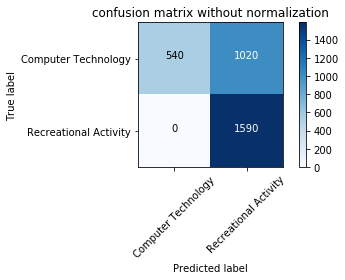

Accuracy: 0.6761904761904762
Recall: 1.0
Precision: 0.6091954022988506
F1-Score: 0.7571428571428572
--- PART B: Cross-Validation ---
Best value of γ =  100  is obtained with cross validation score of  0.8672778089511748

Best SVM ----------------------------
Confusion Matrix: 
Confusion matrix, without normalization
[[1504   56]
 [  32 1558]]


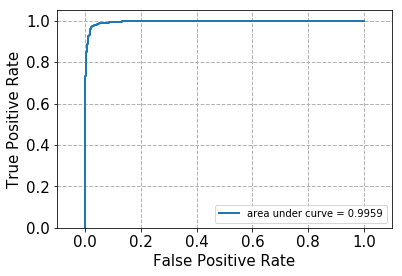

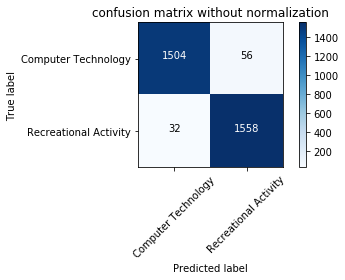

Accuracy: 0.9720634920634921
Recall: 0.979874213836478
Precision: 0.9653035935563816
F1-Score: 0.9725343320848939


In [24]:
"""
QUESTION 4
"""
print("----------- QUESTION 4 -----------")

cat_0 = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
cat_1 = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
classes = ['Computer Technology', 'Recreational Activity']

# Classify the dataset into 2 categories
def classify(dataset):
    cat = []
    for i in dataset.target:
        if(i < 4):
            cat.append(0)
        else: 
            cat.append(1)
    return(cat)


y_train = classify(train_dataset)    
y_test = classify(test_dataset)              

svm_hard = LinearSVC(C = 1000, random_state = 42)
svm_soft = LinearSVC(C = 0.0001, random_state = 42)

def question4(svm):
    svm.fit(X_train_LSI, y_train)	
    
    # ----------------------
    # ROC Curves
    test_score = svm.decision_function(X_test_LSI)
    fpr, tpr, threshold = roc_curve(y_test, test_score)
    plot_roc(fpr, tpr)
    
    # ----------------------
    # Metrics
    y_test_predict = svm.predict(X_test_LSI)
    
    confusionMatrix = confusion_matrix(y_test, y_test_predict)
    accuracy = accuracy_score(y_test, y_test_predict)
    recall = recall_score(y_test, y_test_predict)
    precision = precision_score(y_test, y_test_predict)
    f1_score = 2/((1/recall) + (1/precision))
    
    print('Confusion Matrix: ')
    plt.figure()
    #plot_confusion_matrix(confusionMatrix, classes=classes, normalize=True, title='Normalized confusion matrix')
    plot_confusion_matrix(confusionMatrix, classes=classes,title='confusion matrix without normalization')
    plt.show()
    print('Accuracy:', accuracy)
    print('Recall:', recall)
    print('Precision:', precision)
    print('F1-Score:', f1_score)


print('\nHard Margin ----------------------------')
question4(svm_hard)
print('\nSoft Margin ----------------------------')
question4(svm_soft)

print("--- PART B: Cross-Validation ---")
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

C_best = 0;
max_score = 0;

for i in range(-3, 4): 
    C = 10**i;
    clf = LinearSVC(C = C,random_state=42);
    scores = cross_val_score(clf, X_train_LSI, train_dataset.target, cv=5).mean()
    #print('Mean score: ', scores)
    
    if(scores > max_score):
        max_score = scores
        C_best = C
    
print('Best value of \u03B3 = ', C_best, ' is obtained with cross validation score of ', max_score)
svm_best = LinearSVC(C = C_best,random_state=42)
print('\nBest SVM ----------------------------')
question4(svm_best)

----------- QUESTION 5 -----------
--------ROC curve and scores without regularization--------
Confusion Matrix: 
Confusion matrix, without normalization
[[  78 1482]
 [   0 1590]]


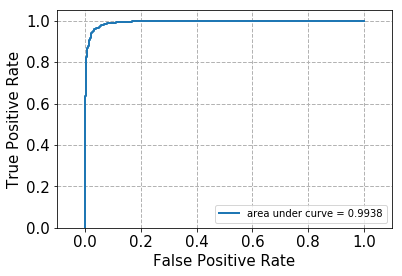

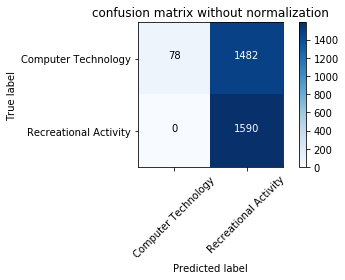

Accuracy: 0.5295238095238095
Recall: 1.0
Precision: 0.517578125
F1: 0.6821106821106822





--------find the best k for L1 regularization--------


D:\Anaconda\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\envs\py3\lib\site-packages\sklearn\metrics\classification.py:113

the score list is  [0.33485689985281036, 0.8887268757299228, 0.9564255566832308, 0.9659428229680949, 0.9720793642214719, 0.9712329692683621, 0.9712331560782627]
the best k for L1 regularization is  1





--------find the best k for L2 regularization--------


D:\Anaconda\envs\py3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


the score list is  [0.596931159133188, 0.9092450204075643, 0.9608798698861154, 0.967005452562705, 0.9720791600309994, 0.9720788770507994, 0.9714445080221648]
the best k for L1 regularization is  1





--------ROC curve and scores for L1 regularization with k=1--------
Confusion Matrix: 
Confusion matrix, without normalization
[[1500   60]
 [  32 1558]]


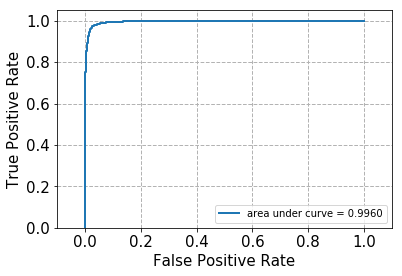

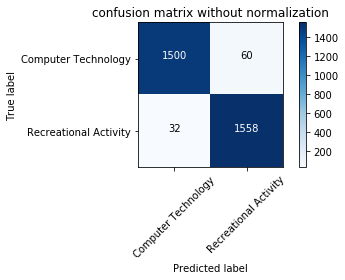

Accuracy: 0.9707936507936508
Recall: 0.979874213836478
Precision: 0.9629171817058096
F1: 0.9713216957605986





--------ROC curve and scores for L2 regularization with k=1--------
Confusion Matrix: 
Confusion matrix, without normalization
[[1500   60]
 [  28 1562]]


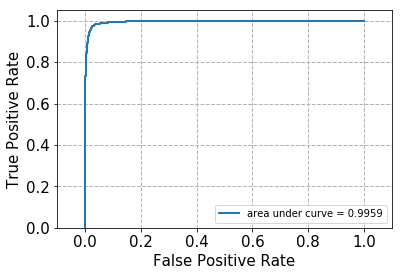

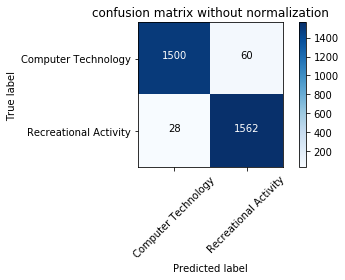

Accuracy: 0.9720634920634921
Recall: 0.9823899371069182
Precision: 0.9630086313193588
F1: 0.9726027397260274







In [21]:
"""
QUESTION 5
"""
print("----------- QUESTION 5 -----------")
def logistic_train_plot_score(clf):
    # train a model
    clf.fit(X_train_LSI,y_train)
    
    # plot ROC curve
    test_score = clf.decision_function(X_test_LSI)
    fpr, tpr, threshold = roc_curve(y_test, test_score)
    plot_roc(fpr, tpr)   
    
    # calculate scores
    y_test_predict = clf.predict(X_test_LSI)
    
    confusionMatrix = confusion_matrix(y_test, y_test_predict)
    accuracy = accuracy_score(y_test, y_test_predict)
    recall = recall_score(y_test, y_test_predict)
    precision = precision_score(y_test, y_test_predict)
    f1_score = 2/((1/recall) + (1/precision))   
    print('Confusion Matrix: ')
    plt.figure()
    plot_confusion_matrix(confusionMatrix, classes=classes, title='confusion matrix without normalization')
    #plot_confusion_matrix(confusionMatrix, classes=classes, normalize=True,title='normalized confusion matrix')
    plt.show()
    print('Accuracy:', accuracy)
    print('Recall:', recall)
    print('Precision:', precision)
    print('F1:', f1_score)

# ROC curve and scores for logistic regression without regularization
print("--------ROC curve and scores without regularization--------")
clf_logistic = LogisticRegression(C=0.00000000001,random_state=42)
logistic_train_plot_score(clf_logistic)
print('\n\n\n\n')



# 5-fold cross validation to find the best C for L1 regularization and L2 regularization
def score_with_k(pen):
    score_list = []
    k_list = range(-3,4)
    for k in k_list:
        clf = LogisticRegression(penalty=pen, C=10**k, random_state=42)
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        scores = cross_val_score(clf, X_train_LSI, y_train, cv=cv, scoring='f1_macro')
        avg_score = np.average(scores)
        score_list.append(avg_score)
    print("the score list is ",score_list)
    best_k_loc = np.argmax(score_list)
    best_k = k_list[best_k_loc]
    return best_k

# best k for L1-regularization 
print("--------find the best k for L1 regularization--------")
best_k_L1 = score_with_k('l1')
print("the best k for L1 regularization is ",best_k_L1)
print('\n\n\n\n')

# best k for L2-regularization
print("--------find the best k for L2 regularization--------")
best_k_L2 = score_with_k('l2')
print("the best k for L1 regularization is ",best_k_L2)
print('\n\n\n\n')
    
    
# ROC curve and scores for logistic regression with L1 regularization
print("--------ROC curve and scores for L1 regularization with k=1--------")
clf_logistic_L1 = LogisticRegression(penalty='l1',C=10**best_k_L1, random_state=42)
logistic_train_plot_score(clf_logistic_L1)
print('\n\n\n\n')

# ROC curve and scores for logistic regression with L2 regularization
print("--------ROC curve and scores for L2 regularization with k=1--------")
clf_logistic_L2 = LogisticRegression(penalty='l2',C=10**best_k_L2, random_state=42)
logistic_train_plot_score(clf_logistic_L2)
print('\n\n\n\n')

----------- QUESTION 6 -----------
Micro-Average ROC Curve
Marco-Average ROC Curve
Normalized confusion matrix
[[0.8  0.04 0.04 0.01 0.09 0.01 0.01 0.01]
 [0.16 0.54 0.14 0.03 0.09 0.01 0.02 0.01]
 [0.11 0.06 0.6  0.12 0.06 0.02 0.01 0.01]
 [0.06 0.05 0.19 0.59 0.08 0.02 0.02 0.01]
 [0.02 0.01 0.03 0.   0.89 0.04 0.02 0.01]
 [0.01 0.01 0.03 0.01 0.24 0.69 0.02 0.01]
 [0.01 0.01 0.01 0.01 0.08 0.01 0.83 0.05]
 [0.01 0.   0.02 0.02 0.02 0.02 0.18 0.73]]


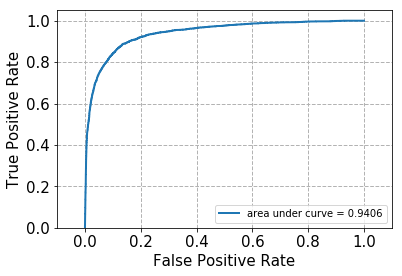

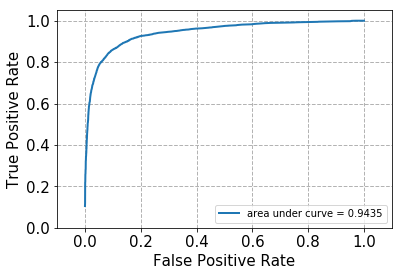

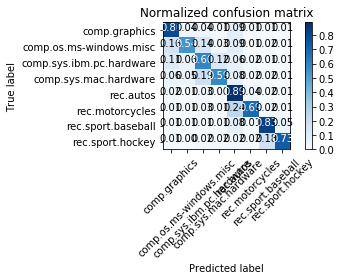

Accuracy:  0.7095238095238096
Recall:  0.7095238095238096
Precision:  0.7302125056777622
F1:  0.7302125056777622


In [10]:
"""
QUESTION 6
"""
print("----------- QUESTION 6 -----------")

# plot ROC curve
classifierNB_score = GaussianNB().fit(X_train_LSI, train_dataset.target).predict_proba(X_test_LSI)
BinaryLabel = label_binarize(test_dataset.target, classes=np.unique(test_dataset.target))  # Binarize the output
n_classes = BinaryLabel.shape[1]

print("Micro-Average ROC Curve")
fpr, tpr, _ = roc_curve(BinaryLabel.ravel(), classifierNB_score.ravel())
plot_roc(fpr, tpr)

print("Marco-Average ROC Curve")
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(BinaryLabel[:, i], classifierNB_score[:, i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
plot_roc(all_fpr, mean_tpr)

# Classify by Gaussian Naive Bayes 
classifierNB = GaussianNB().fit(X_train_LSI, train_dataset.target).predict(X_test_LSI)

# Compute confusion matrix
cnf_matrix_NB = confusion_matrix(test_dataset.target, classifierNB)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_NB, classes=test_dataset.target_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Calculate 4 scores 
accuracy_NB = accuracy_score(test_dataset.target, classifierNB)
print("Accuracy: ", accuracy_NB)
recall_NB = recall_score(test_dataset.target, classifierNB, average='weighted')
print("Recall: ",recall_NB)
precision_NB = precision_score(test_dataset.target, classifierNB, average='weighted')
print("Precision: ",precision_NB)
f1_NB = f1_score(test_dataset.target, classifierNB, average='weighted')
print("F1: ",precision_NB)


In [ ]:
"""
QUESTION 8
"""

print("----------- QUESTION 8 -----------")

# import data and generate LSI-reduced TF-IDF matrix
categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']
train_dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
test_dataset = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

ps = nltk.stem.PorterStemmer()
wnl = nltk.wordnet.WordNetLemmatizer()     

def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

analyzer = text.CountVectorizer().build_analyzer()
vectorizer = text.CountVectorizer(min_df=3, stop_words='english', analyzer=stem_rmv_punc, token_pattern = r'(?u)\b[A-Za-z][A-Za-z]+\b')

X_train_counts = vectorizer.fit_transform(train_dataset.data)
X_train_counts.toarray()
X_test_counts = vectorizer.transform(test_dataset.data)
X_test_counts.toarray()
X_train_tfidf = text.TfidfTransformer().fit_transform(X_train_counts)
print('Shape of TF-IDF train matrices subset: ')
print(X_train_tfidf.shape)
X_test_tfidf = text.TfidfTransformer().fit_transform(X_test_counts)
print('Shape of TF-IDF test matrices subset: ')
print(X_test_tfidf.shape)

#LSI: 
from sklearn.decomposition import TruncatedSVD
lsi = TruncatedSVD(n_components=50, random_state=42) 
X_train_LSI = lsi.fit_transform(X_train_tfidf)
X_test_LSI = lsi.transform(X_test_tfidf)

#NMF:
from sklearn.decomposition import NMF
nmf = NMF(n_components=50, random_state=42)
X_train_NMF = nmf.fit_transform(X_train_tfidf)
X_test_NMF = nmf.transform(X_test_tfidf)

X_train_target = train_dataset.target
X_test_target = test_dataset.target

# For plotting confusion matrix and compute metrics: 
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.tight_layout()
    
# Multiclass SVM (one vs. one)

from sklearn import svm
from sklearn.multiclass import OneVsOneClassifier

print("Multiclass SVM one vs one (with LSI): ")

clf_1v1 = OneVsOneClassifier(svm.SVC(C=1000)).fit(X_train_LSI, X_train_target)
X_predict_1v1 = clf_1v1.predict(X_test_LSI)

cf_mat = confusion_matrix(X_test_target, X_predict_1v1)
np.set_printoptions(precision=2)

#Plot confusion matrices -- unnormalized and normalized
plt.figure()
plot_confusion_matrix(cf_mat, classes=categories,
                      title='Confusion Matrix (1v1 SVM, LSI)')
plt.figure()
plot_confusion_matrix(cf_mat, classes=categories, normalize=True,
                      title='Confusion Matrix (Normalized, 1v1 SVM, LSI)')
plt.show()

# Compute Metrics: 
accuracy = accuracy_score(X_test_target, X_predict_1v1)
recall = recall_score(X_test_target, X_predict_1v1, average='weighted')
precision = precision_score(X_test_target, X_predict_1v1, average='weighted')
f1 = f1_score(X_test_target, X_predict_1v1, average='weighted')


print("Accuracy:  ", accuracy)
print("Recall:    ", recall)
print("Precision: ", precision)
print("F1: ", precision_NB)

print("Multiclass SVM one vs one (with NMF): ")

clf_1v1 = OneVsOneClassifier(svm.SVC(C=1000)).fit(X_train_NMF, X_train_target)
X_predict_1v1 = clf_1v1.predict(X_test_NMF)

cf_mat = confusion_matrix(X_test_target, X_predict_1v1)
np.set_printoptions(precision=2)

#Plot confusion matrices -- unnormalized and normalized
plt.figure()
plot_confusion_matrix(cf_mat, classes=categories,
                      title='Confusion Matrix (1v1 SVM, NMF)')
plt.figure()
plot_confusion_matrix(cf_mat, classes=categories, normalize=True,
                      title='Confusion Matrix (Normalized, 1v1 SVM, NMF)')
plt.show()

# Compute Metrics: 
accuracy = accuracy_score(X_test_target, X_predict_1v1)
recall = recall_score(X_test_target, X_predict_1v1, average='weighted')
precision = precision_score(X_test_target, X_predict_1v1, average='weighted')
f1 = f1_score(X_test_target, X_predict_1v1, average='weighted')

print("Accuracy:  ", accuracy)
print("Recall:    ",recall)
print("Precision: ",precision)
print("F1: ", f1)

# Multiclass SVM (one vs. the rest)

from sklearn.multiclass import OneVsRestClassifier

print("Multiclass SVM one vs the rest (with LSI): ")

clf_1vR = OneVsRestClassifier(svm.SVC(C=1000)).fit(X_train_LSI, X_train_target)
X_predict_1vR = clf_1vR.predict(X_test_LSI)

cf_mat = confusion_matrix(X_test_target, X_predict_1vR)
np.set_printoptions(precision=2)

#Plot confusion matrices -- unnormalized and normalized
plt.figure()
plot_confusion_matrix(cf_mat, classes=categories,
                      title='Confusion Matrix (1vR SVM, LSI)')
plt.figure()
plot_confusion_matrix(cf_mat, classes=categories, normalize=True,
                      title='Confusion Matrix (Normalized, 1vR SVM, LSI)')
plt.show()

# Compute Metrics: 
accuracy = accuracy_score(X_test_target, X_predict_1vR)
recall = recall_score(X_test_target, X_predict_1vR, average='weighted')
precision = precision_score(X_test_target, X_predict_1vR, average='weighted')
f1 = f1_score(X_test_target, X_predict_1v1, average='weighted')

print("Accuracy:  ", accuracy)
print("Recall:    ", recall)
print("Precision: ", precision)
print("F1: ", f1)

print("Multiclass SVM one vs the rest (with NMF): ")

clf_1vR = OneVsRestClassifier(svm.SVC(C=1000)).fit(X_train_NMF, X_train_target)
X_predict_1vR = clf_1vR.predict(X_test_NMF)

cf_mat = confusion_matrix(X_test_target, X_predict_1vR)
np.set_printoptions(precision=2)

#Plot confusion matrices -- unnormalized and normalized
plt.figure()
plot_confusion_matrix(cf_mat, classes=categories,
                      title='Confusion Matrix (1vR SVM, NMF)')
plt.figure()
plot_confusion_matrix(cf_mat, classes=categories, normalize=True,
                      title='Confusion Matrix (Normalized, 1vR SVM, NMF)')
plt.show()

# Compute Metrics: 
accuracy = accuracy_score(X_test_target, X_predict_1vR)
recall = recall_score(X_test_target, X_predict_1vR, average='weighted')
precision = precision_score(X_test_target, X_predict_1vR, average='weighted')
f1 = f1_score(X_test_target, X_predict_1v1, average='weighted')

print("Accuracy:  ", accuracy)
print("Recall:    ",recall)
print("Precision: ",precision)
print("F1: ", f1)

# Multiclass Naive Bayes with NMF

from sklearn.naive_bayes import MultinomialNB
print("Multiclass Naive Bayes (with NMF): ")

mnb = MultinomialNB()
mnb.fit(X_train_NMF, X_train_target)
X_predict_NB = mnb.predict(X_test_NMF)

cf_mat = confusion_matrix(X_test_target, X_predict_NB)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cf_mat, classes=categories,
                      title='Confusion Matrix (NB)')

plt.figure()
plot_confusion_matrix(cf_mat, classes=categories, normalize=True,
                      title='Confusion Matrix (Normalized, NB)')

plt.show()

# Compute Metrics: 
accuracy = accuracy_score(X_test_target, X_predict_NB)
recall = recall_score(X_test_target, X_predict_NB, average='weighted')
precision = precision_score(X_test_target, X_predict_NB, average='weighted')
f1 = f1_score(X_test_target, X_predict_1v1, average='weighted')
print("Accuracy:  ", accuracy)
print("Recall:    ", recall)
print("Precision: ", precision)
print("F1 :", f1)